# Chargement des données

In [86]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import codecs
import re
import os.path
import string
import unicodedata
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import sklearn.naive_bayes as nb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm, linear_model
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix, average_precision_score
from sklearn.feature_extraction.text import CountVectorizer
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


In [87]:
# Chargement des données:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs

path = "/Users/antoinedegenne/Desktop/PAPT/3A/Web_semantique/Vincent/tuto_TAL-main-3/notebooks/ressources/movies/movies1000/"
alltxts,alllabs = load_movies(path)

# Description des données

In [88]:
# Nombre de phrase
print("Nombre de phrase : ", len(alltxts))

# Mise en évidénce du cas déséquilibré
print("Nombre d'étiquettes 1 : ", alllabs.count(1), " (",round(alllabs.count(1)/len(alllabs),2),")")
print("Nombre d'étiquettes 0 : ", alllabs.count(0), " (",round(alllabs.count(0)/len(alllabs),2),")")

Nombre de phrase :  2000
Nombre d'étiquettes 1 :  1000  ( 0.5 )
Nombre d'étiquettes 0 :  1000  ( 0.5 )


In [89]:
# Fonctions de prétraitements basiques

# Supprimer la ponctuation et les chiffres de toutes les phrases
def suppr_ponct(txt): # prend alltxts en entrée
    punc = string.punctuation  
    punc += '\n\r\t'

    for i in range(len(txt)):
        txt[i] = txt[i].translate(str.maketrans(punc, ' ' * len(punc)))  
        txt[i] = re.sub('[0-9]+', '', txt[i])

# Supprimer les accents et caractères spéciaux
def suppr_accents_maj(txt): # prend alltxts en entrée
    for i in range(len(txt)):
        txt[i] = unicodedata.normalize('NFD',  txt[i]).encode('ascii', 'ignore').decode("utf-8")
        txt[i] =  txt[i].lower()

In [90]:
# Génération du dictionnaire {"mot" : occurence_documentaire}
suppr_ponct(alltxts)
suppr_accents_maj(alltxts)

words = []
for i in range(len(alltxts)):
    mots_vus = []
    for mot in alltxts[i].split():
        if mot not in mots_vus: # on ajoute 1 seule fois le mot s'il apparait dans la phrase --> occurence documentaire et pas totale
            words.append(mot)
            mots_vus.append(mot)


from collections import Counter

dico = Counter(words)

# Dico qui associe 1 mot à sa position dans le dictionnaire dico
trans = dict(zip(list(dico.keys()), np.arange(len(dico)).tolist()))

# Extraction du vocabulaire

In [91]:
# Extraction du vocabulaire
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(alltxts)

print("Taille du vocabulaire : ",len(vectorizer.get_feature_names()))


Taille du vocabulaire :  38890


/Users/antoinedegenne/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


100 mots les plus apparus :  [('the', 1999), ('of', 1998), ('and', 1998), ('to', 1997), ('a', 1996), ('is', 1995), ('in', 1994), ('it', 1967), ('s', 1966), ('that', 1963), ('with', 1944), ('for', 1922), ('as', 1920), ('but', 1903), ('this', 1896), ('on', 1861), ('an', 1785), ('by', 1782), ('are', 1781), ('one', 1776), ('be', 1774), ('his', 1756), ('film', 1753), ('who', 1749), ('at', 1720), ('from', 1702), ('t', 1688), ('he', 1686), ('not', 1681), ('have', 1631), ('has', 1606), ('all', 1603), ('i', 1576), ('movie', 1554), ('out', 1539), ('like', 1497), ('there', 1496), ('was', 1496), ('they', 1495), ('so', 1484), ('you', 1474), ('more', 1469), ('up', 1461), ('about', 1461), ('when', 1449), ('what', 1399), ('or', 1388), ('can', 1368), ('some', 1365), ('if', 1350), ('just', 1327), ('which', 1320), ('into', 1310), ('only', 1309), ('their', 1295), ('even', 1291), ('than', 1284), ('time', 1258), ('no', 1206), ('most', 1186), ('good', 1182), ('much', 1138), ('would', 1136), ('him', 1130), ('

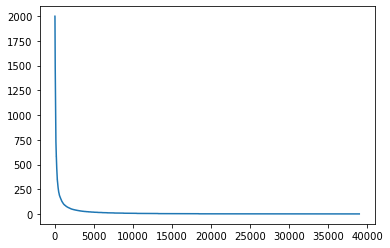

In [92]:
# Affichage des 100 mots les plus apparus dans les phrases
print("100 mots les plus apparus : ",dico.most_common(100))
freq = [f for w,f in dico.most_common()]

plt.plot(freq)

# Transformation paramétrique du texte

In [93]:
# DEFINITION DES FONCTIONS DE PRETRAITEMENT

# Data augmentation pour rééquilibrer les classes
def data_augmentation(txt,labs):
    liste_positions = []
    for i in labs:
        liste_positions.append(i == 1) 

    liste_classe_minoritaire = itertools.compress(txt, liste_positions)

    txts_bis = []
    for each in liste_classe_minoritaire:
        txts_bis.append(each)

    for elem in txts_bis: # nombre d'ajout trouvé de manière empirique pour avoir environ 50/50
        txt.append(elem)
        txt.append(elem)
        txt.append(elem)
        txt.append(elem)
        txt.append(elem)
        labs.append(1)
        labs.append(1)
        labs.append(1)
        labs.append(1)
        labs.append(1)

# Stemming
def stemming(txt):
    ps = PorterStemmer()
    compteur = 0
    for sentence in txt:
        # print("sentence : ",sentence)
        words = word_tokenize(sentence,language='french')
        # print("words : ",words)
        sentence_new = ''
        for word in words:
            word_new = ps.stem(word)
            sentence_new += word_new + ' '
        txt[compteur] = sentence_new
        compteur += 1

# Stopword
stop_words = stopwords.words('french')



In [94]:
# MISE EN PLACE DES PRETRAITEMENTS --> GENERATION DE DIFFERENTS JEUX DE DONNEES
# 3 prétraitrements différents : prétaitements basiques + stop words + stemming, n-gram niveau mots, n-gram niveau caractères

# Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(alltxts, alllabs, test_size=0.3, random_state=0)


# On ajoute à liste_donnees différents jeux de données issus de différents pré-traitements
liste_donnees = []

# Prétraitement par stemming commun à tous les jeux de données
stemming(X_train)
stemming(X_test)

#######################################
# PRETRAITEMENTS SANS DATA AUGMENTATION
#######################################
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()
y_train_1 = y_train.copy()
y_test_1 = y_test.copy()

# Prétraitement avec pré-traitements basiques + stop words + stemming
vectorizer = CountVectorizer(stop_words = stop_words, min_df = 2)
X_train_vec = vectorizer.fit_transform(X_train_1)
X_test_vec = vectorizer.transform(X_test_1)
liste_donnees.append([X_train_vec,y_train_1,X_test_vec,y_test_1,len(vectorizer.get_feature_names()), "Prétraitements basiques + stopwords + stemming : "])

# Prétraitement avec bigram et trigram au niv mot (+ pré-traitements basiques + stop words + stemming)
vectorizer = CountVectorizer(stop_words = stop_words, ngram_range=(1,3), analyzer='word', min_df = 2)
X_train_vec = vectorizer.fit_transform(X_train_1)
X_test_vec = vectorizer.transform(X_test_1)
liste_donnees.append([X_train_vec,y_train_1,X_test_vec,y_test_1,len(vectorizer.get_feature_names()), "Prétraitements basiques + stopwords + stemming + bigram/trigram niveau mot : "])

# Prétraitement avec bigram et trigram au niv caractère (+ pré-traitements basiques + stop words + stemming)
vectorizer = CountVectorizer(stop_words = stop_words,ngram_range=(2,4), analyzer='char', min_df = 2)
X_train_vec = vectorizer.fit_transform(X_train_1)
X_test_vec = vectorizer.transform(X_test_1)
liste_donnees.append([X_train_vec,y_train_1,X_test_vec,y_test_1,len(vectorizer.get_feature_names()), "Prétraitements basiques + stopwords + stemming + bigram/trigram niveau caractère: "])


In [95]:
# Taille du vocabulaire des données issues des différents pré-traitements
for liste in liste_donnees:
    print(liste[5])
    print("Taille vocab : ",liste[4])

Prétraitements basiques + stopwords + stemming : 
Taille vocab :  13817
Prétraitements basiques + stopwords + stemming + bigram/trigram niveau mot : 
Taille vocab :  155194
Prétraitements basiques + stopwords + stemming + bigram/trigram niveau caractère: 
Taille vocab :  40637


# Effets des différents prétraitements sur les performances

In [96]:
modeles = []

compteur = 0
for liste in liste_donnees: # remplacer liste_donnees par [liste_donnees[i]] pour tester un des jeux de données prétraité en particulier sinon ça prend beaucoup de temps
    compteur += 1

    # Pour chaque jeu de données prétraitées, on fit 3 classifieurs
    # Pour chaque classifieur, on optimise ses paramètres en train avec gridSearch et on regarde les perf du meilleur estimateur en test
    ## Linear SVM
    print("\nentree SVM")
    clf_svm = svm.LinearSVC(random_state=0, tol=1e-5, max_iter = 10000)
    param_grid_svm = {'C': [0.0001, 0.001, 0.01, 0.1]}
    grid_svm = GridSearchCV(clf_svm, param_grid = param_grid_svm, n_jobs=3)
    grid_svm.fit(liste[0],liste[1])

    ## logistic regression
    print("entree Reg Log")
    clf_log = LogisticRegression(max_iter = 10000)
    param_grid_log = {'C': [0.0001, 0.001, 0.01, 0.1]}
    grid_log = GridSearchCV(clf_log, param_grid = param_grid_log, n_jobs=3)
    grid_log.fit(liste[0],liste[1])

    ## Naives Bayes
    print("entree Naives Bayes")
    clf_nvb = MultinomialNB()
    param_grid_nvb = {'alpha': [0.1, 0.5, 0.8, 1]}
    grid_nvb = GridSearchCV(clf_nvb, param_grid = param_grid_nvb, n_jobs=3)
    grid_nvb.fit(liste[0],liste[1])
    
    

    print(" ")
    print(liste[5])
    print("taille vocabulaire : ",liste[4])
    
    print("SVM - paramètre C optimal :", grid_svm.best_params_)
    print("SVM - Perf en apprentissage (avec C optimal) : ",grid_svm.best_estimator_.score(liste[0],liste[1]))
    

    print("Reg logisti - paramètre C optimal :", grid_log.best_params_)
    print("Reg logisti - Perf en apprentissage  (avec C optimal) : ",grid_log.best_estimator_.score(liste[0],liste[1]))


    print("Naives Bayes - paramètre alpha optimal :", grid_nvb.best_params_)
    print("Naives Bayes - Perf en apprentissage  (avec alpha optimal) : ",grid_nvb.best_estimator_.score(liste[0],liste[1]))



    modeles.append([grid_svm.best_estimator_, "Best SVM",liste[2],liste[3]])
    modeles.append([grid_log.best_estimator_, "Best Reg Log",liste[2],liste[3]])
    modeles.append([grid_nvb.best_estimator_, "Best Naives Bayes",liste[2],liste[3]])
    



entree SVM
entree Reg Log
entree Naives Bayes
 
Prétraitements basiques + stopwords + stemming : 
taille vocabulaire :  13817
SVM - paramètre C optimal : {'C': 0.001}
SVM - Perf en apprentissage (avec C optimal) :  0.9907142857142858
Reg logisti - paramètre C optimal : {'C': 0.01}
Reg logisti - Perf en apprentissage  (avec C optimal) :  0.9871428571428571
Naives Bayes - paramètre alpha optimal : {'alpha': 0.8}
Naives Bayes - Perf en apprentissage  (avec alpha optimal) :  0.9571428571428572

entree SVM
entree Reg Log
entree Naives Bayes
 
Prétraitements basiques + stopwords + stemming + bigram/trigram niveau mot : 
taille vocabulaire :  155194
SVM - paramètre C optimal : {'C': 0.001}
SVM - Perf en apprentissage (avec C optimal) :  1.0
Reg logisti - paramètre C optimal : {'C': 0.1}
Reg logisti - Perf en apprentissage  (avec C optimal) :  1.0
Naives Bayes - paramètre alpha optimal : {'alpha': 0.5}
Naives Bayes - Perf en apprentissage  (avec alpha optimal) :  1.0

entree SVM
entree Reg Lo

In [97]:
# On construit le modèle final correspondant au vote de plusieurs modèles
# Et on calcule ses performances en test
y_pred = []
y_moy = []
modeles_selectionnees = [modeles[3],modeles[4],modeles[5]] # Indices correspondant aux modèles sélectionnés pour le vote

for mod in modeles_selectionnees: 
    y_pred.append(mod[0].predict(mod[2]))

for i in range(0,len(y_pred[0])):
    if [y[i] for y in y_pred].count(1) > len(modeles_selectionnees)//2: # résultat du "vote" des modèles
        y_moy.append(1)
    else:
        y_moy.append(0)

conf_matrix_0 = confusion_matrix(y_moy, y_test)
conf_matrix = confusion_matrix(y_moy, y_test, normalize = 'true')
print(conf_matrix_0)
print(conf_matrix)


[[252  48]
 [ 56 244]]
[[0.84       0.16      ]
 [0.18666667 0.81333333]]


In [74]:

# Génération du fichier .txt de résultats
import pandas as pd
df = pd.DataFrame({'Phrase': X_test, 'Classe réelle': y_test, 'Classe prédite': y_moy}, columns = ['Phrase', 'Classe réelle', 'Classe prédite'])
df.to_csv("fichier.csv")
